# CO2 Emission Prediction.
Since 1995, the Government of Canada provides model-specific fuel consumption ratings and estimated carbon dioxide (CO2) emissions for new light-duty vehicles for retail sale in the country. This data can be obtained in the [government website](https://open.canada.ca/data/en/dataset/98f1a129-f628-4ce4-b24d-6f16bf24dd64). 

This project aims to create a model capable of predicting a vehicle's estimated CO2 emission in units of g/km, based on the properties provided in the dataset. The data used is from the years of 2018 to 2022.

# Module Importing and Data Loading
First of all, we are going to import the necessary modules for this project and load the dataset.

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('dark')

In [2]:
df = pd.read_csv('data/co2_emission.csv')
df.head()

,model year,make,model,vehicle class,engine size (l),cylinders,transmission,fuel type,fuel consumption city (l/100 km),fuel consumption hwy (l/100 km),fuel consumption comb (l/100 km),fuel consumption comb (mpg),co2 emissions (g/km),co2 rating,smog rating
0,2022,Acura,ILX,Compact,2.4,4,AM8,Z,9.9,7.0,8.6,33,200,6,3
1,2022,Acura,MDX SH-AWD,SUV: Small,3.5,6,AS10,Z,12.6,9.4,11.2,25,263,4,5
2,2022,Acura,RDX SH-AWD,SUV: Small,2.0,4,AS10,Z,11.0,8.6,9.9,29,232,5,6
3,2022,Acura,RDX SH-AWD A-SPEC,SUV: Small,2.0,4,AS10,Z,11.3,9.1,10.3,27,242,5,6
4,2022,Acura,TLX SH-AWD,Compact,2.0,4,AS10,Z,11.2,8.0,9.8,29,230,5,7


In [3]:
print("Number of samples: %.0f" % df.shape[0])
print("Number of features: %.0f" % df.shape[1])

Number of samples: 5003
Number of features: 15


# Data Validation
We need to validate the data and make it analysis-ready.
## Missing Values
Let's begin by checking for missing values:

In [4]:
df.isnull().sum()

model year                          0
make                                0
model                               0
vehicle class                       0
engine size (l)                     0
cylinders                           0
transmission                        0
fuel type                           0
fuel consumption city (l/100 km)    0
fuel consumption hwy (l/100 km)     0
fuel consumption comb (l/100 km)    0
fuel consumption comb (mpg)         0
co2 emissions (g/km)                0
co2 rating                          0
smog rating                         0
dtype: int64

The dataset does not have any missing values.

Following the information on the website, the ``co2 rating`` and the ``smog rating`` features are ratings given to a car after the `co2 emission` is known. Thus, this information cannot be included in our model, as we would like to create a model capable of predicting the CO2 emission of a car based on its features, so are going to remove the ``co2 rating`` and the ``smog rating`` from our analysis.

In [5]:
del df['co2 rating']
del df['smog rating']

Now, let's look at the column types:

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5003 entries, 0 to 5002
Data columns (total 13 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   model year                        5003 non-null   int64  
 1   make                              5003 non-null   object 
 2   model                             5003 non-null   object 
 3   vehicle class                     5003 non-null   object 
 4   engine size (l)                   5003 non-null   float64
 5   cylinders                         5003 non-null   int64  
 6   transmission                      5003 non-null   object 
 7   fuel type                         5003 non-null   object 
 8   fuel consumption city (l/100 km)  5003 non-null   float64
 9   fuel consumption hwy (l/100 km)   5003 non-null   float64
 10  fuel consumption comb (l/100 km)  5003 non-null   float64
 11  fuel consumption comb (mpg)       5003 non-null   int64  
 12  co2 em

The `model year` and `cylinder` columns have the `int64` dtype. Let's look at their unique values:

In [7]:
df['model year'].unique()

array([2022, 2021, 2020, 2019, 2018])

In [8]:
df['cylinders'].unique()

array([ 4,  6,  8, 12, 10, 16,  3,  5])

These are actually categorical columns, as these have discrete values. Let's change the column dtype:

In [9]:
df['model year'] = df['model year'].astype(str)
df['cylinders'] = df['cylinders'].astype(str)

df.dtypes

model year                           object
make                                 object
model                                object
vehicle class                        object
engine size (l)                     float64
cylinders                            object
transmission                         object
fuel type                            object
fuel consumption city (l/100 km)    float64
fuel consumption hwy (l/100 km)     float64
fuel consumption comb (l/100 km)    float64
fuel consumption comb (mpg)           int64
co2 emissions (g/km)                  int64
dtype: object

Now, all the columns have the right dtype. Finally, let's create two lists contaning the name of the numerical and categorical columns.

In [10]:
cat_cols = list(df.loc[:, df.dtypes == object].columns)
num_cols = list(df.loc[:, df.dtypes != object].columns)

# Exploratory Data Analysis
Beforing exploring the data, we are going to split the data into train/validation/test sets, with a 60/20/20% ratio. Then, we follow to analyze the categorical and the numerical features individually.

In [11]:
from sklearn.model_selection import train_test_split

df_train_full, df_test = train_test_split(df, test_size=0.2, random_state=11)
df_train, df_val = train_test_split(df_train_full, test_size=0.25, random_state=11)

## Categorical features

Let's look at how many unique values the categorical columns have:

In [12]:
df_train_full[cat_cols].nunique()

model year          5
make               39
model            1326
vehicle class      15
cylinders           8
transmission       26
fuel type           4
dtype: int64

For each column, we are going to analyze their unique values in a barplot and their distribution of CO2 emission via a boxplot. 

### Model Year

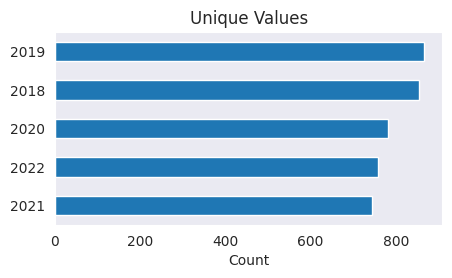

In [13]:
plt.figure(figsize=(5,2.5))
df_train_full['model year'].value_counts().sort_values().plot(kind='barh')
plt.title('Unique Values')
plt.xlabel('Count')
plt.show()

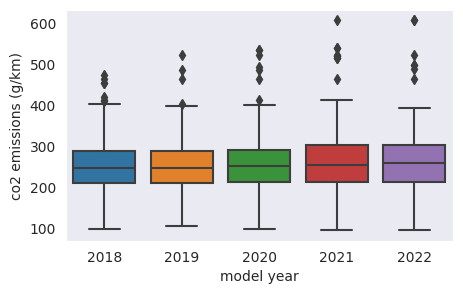

In [14]:
plt.figure(figsize=(5,3))
sns.boxplot(x='model year', 
            y='co2 emissions (g/km)', 
            data=df_train_full.sort_values(by='model year'))
plt.show()

We can see that the CO2 emission has sligthly increased over the years (which is worrying, by the way). 

#### Make
The make column contains information about the car manufacturer.

Unique values in the make column:  39


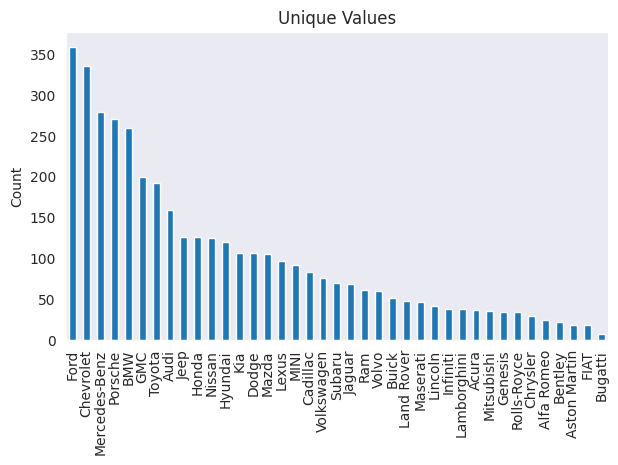

In [15]:
print("Unique values in the make column: ", df_train_full['make'].nunique())
plt.figure(figsize=(7,4))
df_train_full['make'].value_counts().sort_values(ascending=False).plot(kind='bar')
plt.title('Unique Values')
plt.ylabel('Count')
plt.show()

Ford, Chevrolet, Mercedes-Benz, Porsche and BMW are the top 5 manufacturers. Manufacturer's of luxury cars, such as Lamborghini, Rolls-Royce and Bugatti, have very few samples.

Let's see how is the CO2 emission distribution among the manufacturers.

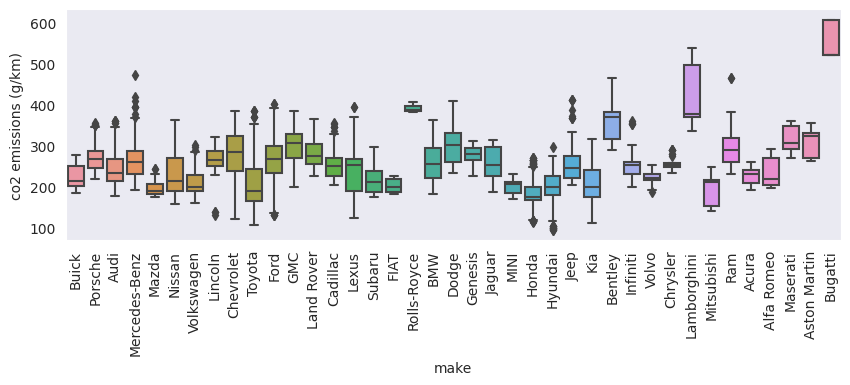

In [16]:
plt.figure(figsize=(10,3))
ax = sns.boxplot(x='make', 
                 y='co2 emissions (g/km)', 
                 data=df_train_full)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show()

The manufacturers present very different distributions of co2 emission. This will be a important feature for our predictions.

Here we can observe some trends:
- Among the cars with the lowest emissions, we find Mazda, Nissan, Toyota, Subaru, Honda and Mitsubishi: all of them are japanese companies. 
- The highest emissions come from manufacturers that produce luxury cars: Rolls-Royce, Bentley, Lamborghini and Bugatti.

### Vehicle Class
Here we have information about the vehicle size (Small, mid-size, compact, etc) and its type (SUV, Pickup truck, van, etc).

Unique values in the vehicle class column:  15


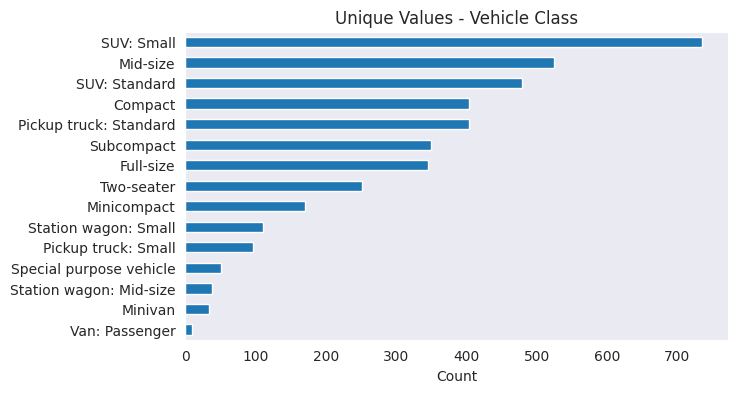

In [17]:
print("Unique values in the vehicle class column: ", df_train_full['vehicle class'].nunique())
plt.figure(figsize=(7,4))
df_train_full['vehicle class'].value_counts().sort_values().plot(kind='barh')
plt.title('Unique Values - Vehicle Class')
plt.xlabel('Count')
plt.show()

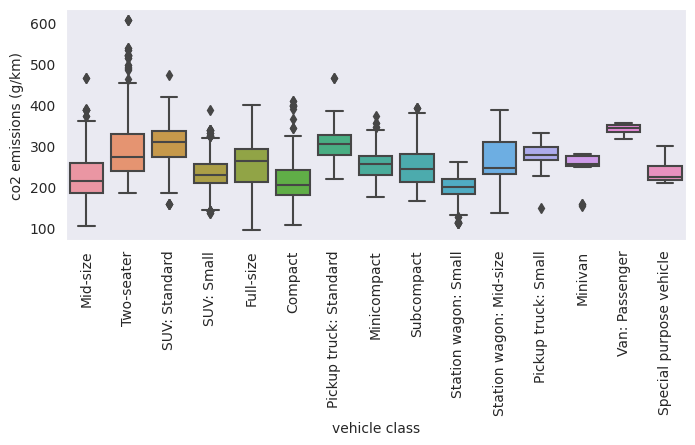

In [18]:
plt.figure(figsize=(8,3))
ax = sns.boxplot(x='vehicle class', 
                 y='co2 emissions (g/km)', 
                 data=df_train_full)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show()

The compact cars are among those that have the lowest C02 emission rates.

### Cylinders

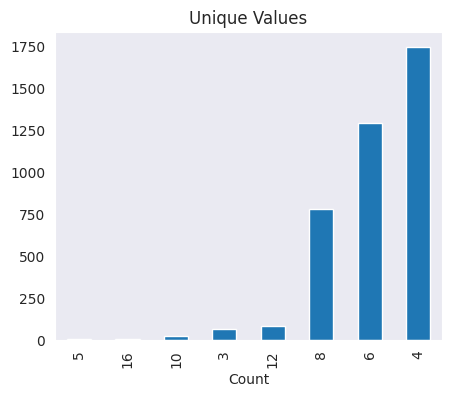

In [19]:
plt.figure(figsize=(5,4))
df_train_full['cylinders'].value_counts().sort_values().plot(kind='bar')
plt.title('Unique Values')
plt.xlabel('Count')
plt.show()

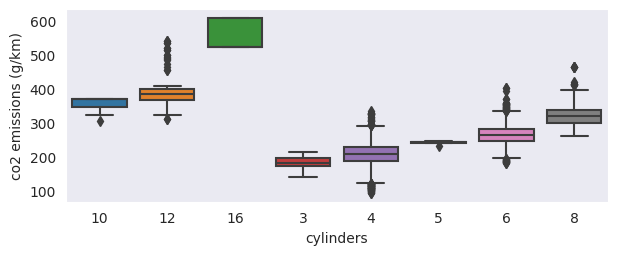

In [20]:
plt.figure(figsize=(7, 2.5))
ax = sns.boxplot(x='cylinders',
                 y='co2 emissions (g/km)', 
                 data=df_train_full.sort_values(by="cylinders"))
plt.show()

Clearly, the CO2 emission rating increases with the cylinders. Thus, this is a very important feature to the model.

### Fuel Type
The fuel type is classified as:

- D = diesel
- E = ethanol (E85)
- X = regular gasoline
- Z = premium gasoline

Unique values in the fuel type column:  4


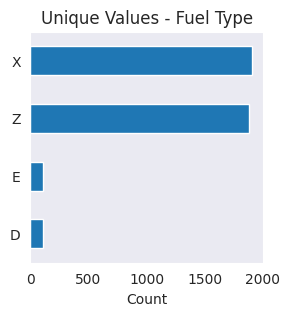

In [21]:
print("Unique values in the fuel type column: ", df_train_full['fuel type'].nunique())
plt.figure(figsize=(3,3))
df_train_full['fuel type'].value_counts().sort_values().plot(kind='barh')
plt.title('Unique Values - Fuel Type')
plt.xlabel('Count')
plt.show()

Most of the cars run by gasoline, with a minority of the running by ethanol and diesel.

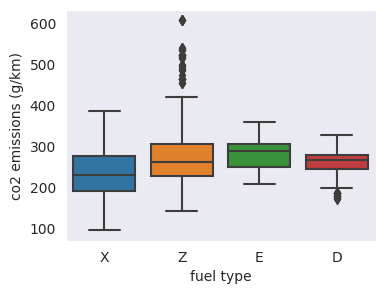

In [22]:
plt.figure(figsize=(4,3))
ax = sns.boxplot(x='fuel type', 
                 y='co2 emissions (g/km)', 
                 data=df_train_full)
plt.show()

Ethanol and diesel cars have consistently high CO2 emission rates, above 200 g/km for more than 95% of the cars. Cars that run by gasoline present some of the highest emission rates, but also some of the lowest.  
### Transmission
The Transmission is classified as:

- A = automatic
- AM = automated manual
- AS = automatic with select shift
- AV = continuously variable
- M = manual

Unique values in the transmission column:  26


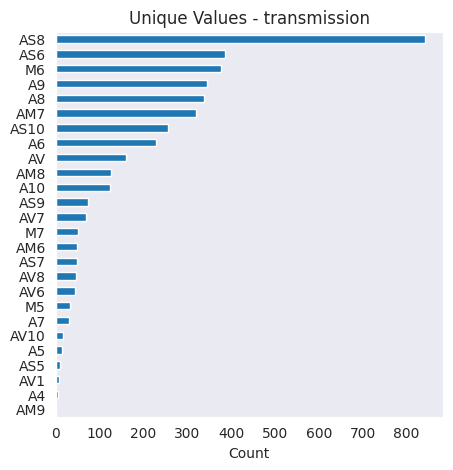

In [23]:
print("Unique values in the transmission column: ", df_train_full['transmission'].nunique())
plt.figure(figsize=(5,5))
df_train_full['transmission'].value_counts().sort_values().plot(kind='barh')
plt.title('Unique Values - transmission')
plt.xlabel('Count')
plt.show()

Most cars have automatic transmissions, with the automatic select shift (AS) being the most frequent. However, the M6 ​​transmission is the third most frequent, showing that manual cars still have a large share of the market. 

Let's check the CO2 emission for the transmissions:

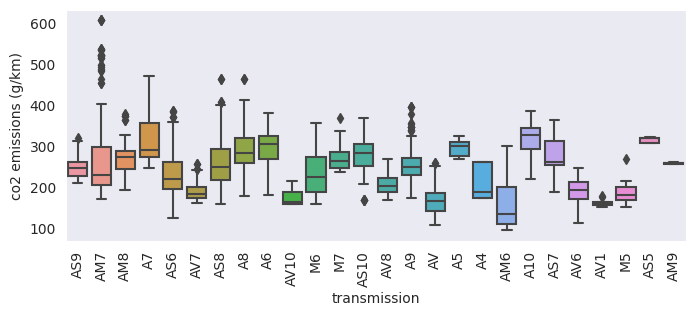

In [24]:
plt.figure(figsize=(8,3))
ax = sns.boxplot(x='transmission', 
                 y='co2 emissions (g/km)', 
                 data=df_train_full)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show()

The highest emissions are among the fully automatic cars (A). The continuously variable (AV) have the lowest CO2 emission ratios. For manual cars, the M5 transmission have low emission rate, whereas the M7 shows high rate and the M6 has a high variance between its samples.

### Model
The model column has many unique values:

In [25]:
df_train_full['model'].nunique()

1326

This column contains 1326 unique values. 

Unique values in the model column:  1326


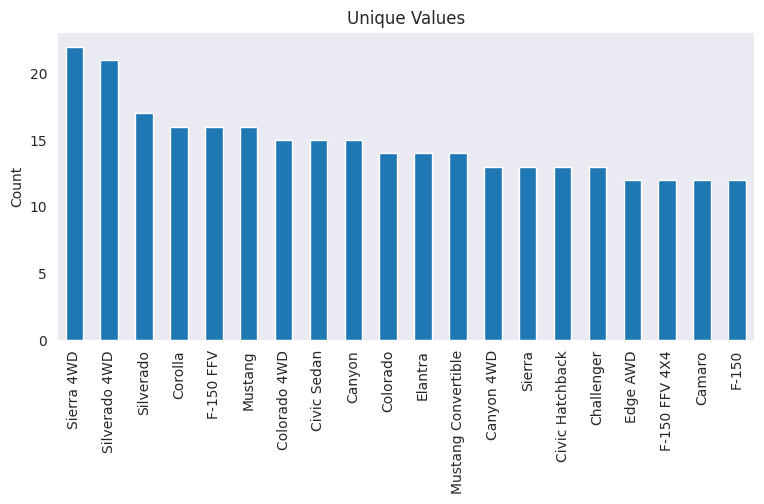

In [26]:
print("Unique values in the model column: ", df_train_full['model'].nunique())
plt.figure(figsize=(9,4))
df_train_full['model'].value_counts().sort_values(ascending=False).head(20).plot(kind='bar')
plt.title('Unique Values')
plt.ylabel('Count')
plt.show()

Let's look at the CO2 emission of the first 20 models about the first 20

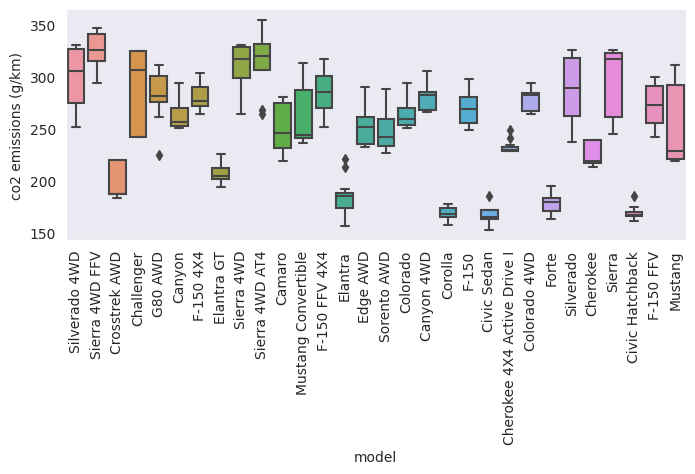

In [27]:
mask = df_train_full['model'].isin(list(df_train_full['model'].value_counts().head(30).index))
top_models = df_train_full[mask]

plt.figure(figsize=(8,3))
ax = sns.boxplot(x='model', 
                 y='co2 emissions (g/km)', 
                 data=top_models)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show()

The distribution of CO2 emission is very different between the car models. However, the high number of unique values can introduce a lot of overfitting to the model; thus, this feature will be removed when training the model in order to avoid this problem. 

## Numerical Features
Now, let's look at the numerical features and their relations with the CO2 emission rating.

- Fuel consumption:	City and highway fuel consumption ratings are shown in litres per 100 kilometres (L/100 km) - the combined rating (55% city, 45% hwy) is shown in L/100 km and in miles per imperial gallon (mpg).

First, let's look at the correlations between the features.

In [28]:
df_train_full[num_cols].corr()

,engine size (l),fuel consumption city (l/100 km),fuel consumption hwy (l/100 km),fuel consumption comb (l/100 km),fuel consumption comb (mpg),co2 emissions (g/km)
engine size (l),1.000000,0.837142,0.757712,0.822162,-0.723847,0.833662
fuel consumption city (l/100 km),0.837142,1.000000,0.933221,0.992027,-0.911873,0.949557
fuel consumption hwy (l/100 km),0.757712,0.933221,1.000000,0.970715,-0.886318,0.916930
fuel consumption comb (l/100 km),0.822162,0.992027,0.970715,1.000000,-0.917156,0.952956
fuel consumption comb (mpg),-0.723847,-0.911873,-0.886318,-0.917156,1.000000,-0.906536
co2 emissions (g/km),0.833662,0.949557,0.916930,0.952956,-0.906536,1.000000


Many of these features are highly correlated, in particular the fuel consumption ratings. If we look at how the data was prepared in the Canada Government website, we find the following information:

*Fuel consumption: City and highway fuel consumption ratings are shown in litres per 100 kilometres (L/100 km) - the combined rating (55% city, 45% hwy) is shown in L/100 km and in miles per imperial gallon (mpg)*

Thus, the 'fuel consumption comb (l/100 km)' column is just a combination of the 'fuel consumption city (l/100 km)' and 'fuel consumption hwy (l/100 km)' columns. Besides, the 'fuel consumption comb (mpg)' is the 'fuel consumption comb (l/100 km)' converted from L/100km to miles per gallon. Let's make a visualization of how they are related to each other:

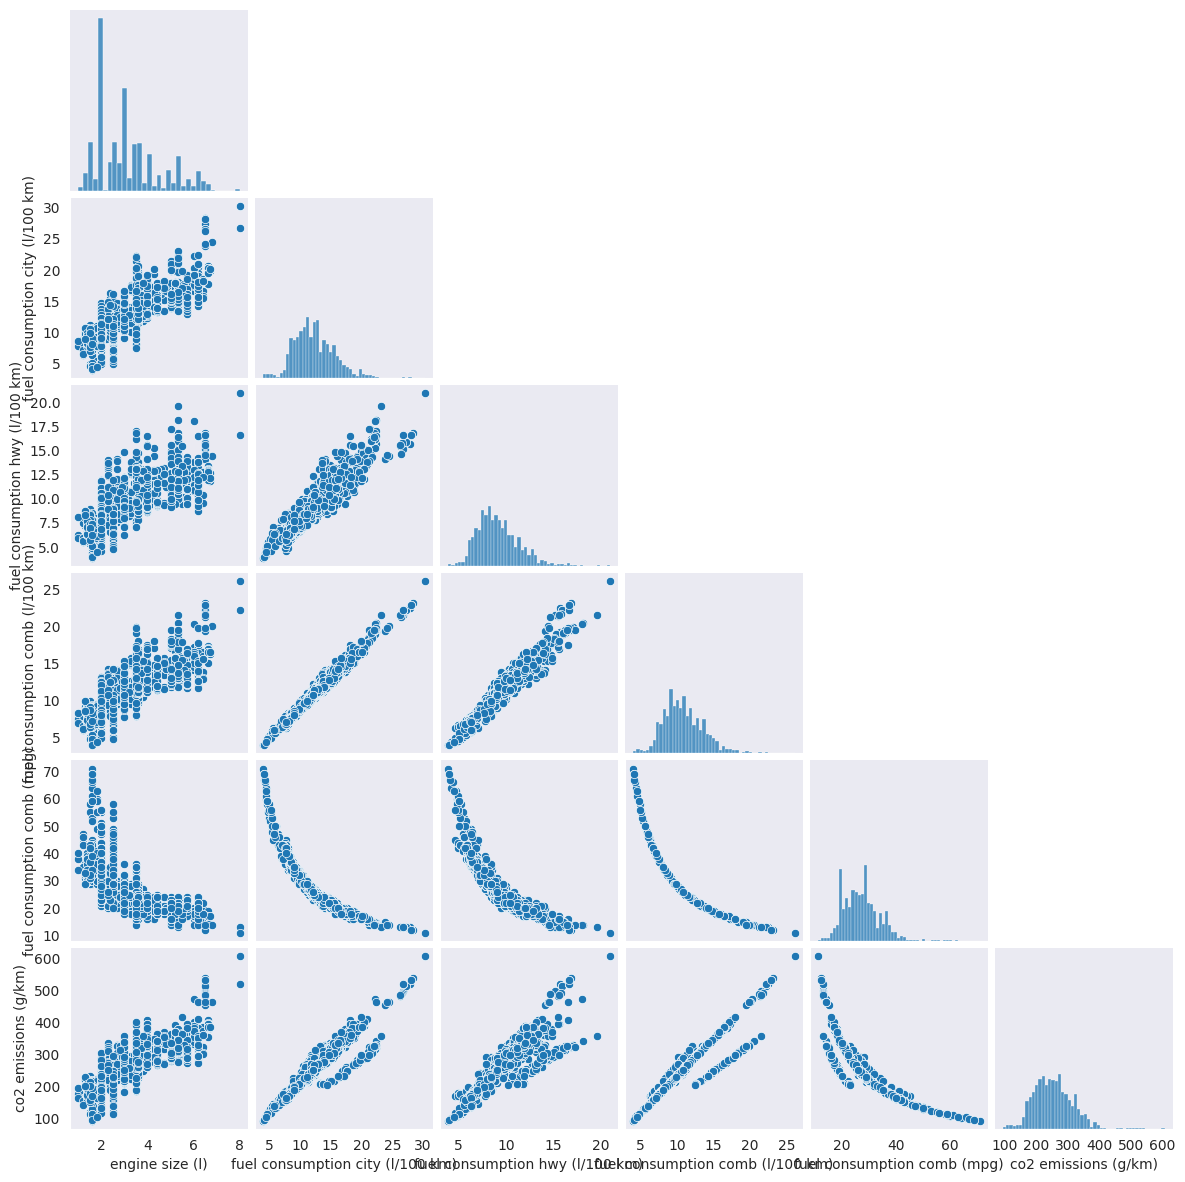

In [29]:
sns.pairplot(df_train_full[num_cols], height=2, corner=True)
sns.set(font_scale=0.6)
plt.show()

As expected, we can see that the 'fuel consumption comb (mpg)' column is highly correlated with the other fuel consumption columns, being inversely proportional to the L/100km rates. Thus, we are going to remove 'fuel consumption comb (mpg)' rating as it contains redundant information.

Although the fuel consumption on city and highway are highly correlated with the CO2 emission, the combination of both (the "fuel consumption comb (l/100 km)" column) has a higher correlation with the CO2 emission. So, in a first approach we are going to use the fuel consumption on city and highway columns, and then we are going to remove them and use only the combination of both, and compare the results. 

# Model Fitting
Our approach will be training a linear and a tree-based model, and compare both performances. We are going to follow these steps:
- We will train a Linear Regression model using just the numerical values. This will be our baseline model: everything that follows must improve the results obtained here.
- As our linear model, we are going to use Ridge Regression.
- Then, we will fit a Random Forest Regressor and a XGBoost Regressor as our tree-based models to compare their performance with the linear model.

In [30]:
# Creating target series
y_train = df_train['co2 emissions (g/km)']
y_val = df_val['co2 emissions (g/km)']

# Removing target from train sets
drop_cols = ['co2 emissions (g/km)', 
             'model', 
             'fuel consumption comb (mpg)',
             'fuel consumption comb (l/100 km)'
            ]

X_train = df_train.drop(drop_cols, axis=1)
X_val = df_val.drop(drop_cols, axis=1)

X_cat_cols = list(X_train.loc[:, X_train.dtypes == object].columns)
X_num_cols = list(X_train.loc[:, X_train.dtypes != object].columns)

Before make some experiments, we are going to create a pipeline to help us fit the models. 

In [31]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

def make_pipeline(model, df):
    """Create a pipeline for a model."""

    cat_transf = OneHotEncoder(sparse=False,
                               handle_unknown="ignore")

    std_scaler = StandardScaler()

    # Determining categorical and numerical columns
    df_cat_cols = list(df.loc[:, df.dtypes == object].columns)
    df_num_cols = list(df.loc[:, df.dtypes != object].columns)

    transformer = ColumnTransformer(transformers=[("cat", cat_transf, df_cat_cols),
                                                  ("num_scaler", std_scaler, df_num_cols)],
                                    remainder='passthrough'
                                   )

    steps = [("transformer", transformer),
             ("model", model)]
    
    return Pipeline(steps)

Finally, let's create a DataFrame to store all the results.

In [32]:
final_scores = pd.DataFrame({"Model": [], 
                             "Dataset": [], 
                             "Score":[]})

## Baseline Model
First, we will create a dataset containing only numerical features, and train a Linear Regression model to serve as baseline. 

In [33]:
X_train_num = df_train[X_num_cols]
X_val_num = df_val[X_num_cols]

In [34]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

lrg = LinearRegression()

pipe_lrg = make_pipeline(lrg, X_train_num) 

pipe_lrg.fit(X_train_num, y_train)

y_pred_train = pipe_lrg.predict(X_train_num)
y_pred_val = pipe_lrg.predict(X_val_num)

lrg_score_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
lrg_score_val = np.sqrt(mean_squared_error(y_val, y_pred_val))

print("RMSE Train = {:0.3f}".format(lrg_score_train))
print("RMSE Validation = {:0.3f}".format(lrg_score_val))

RMSE Train = 17.633
RMSE Validation = 18.067


## Ridge Regression
Now, we will train a Ridge Regression model. Let's use a list of alpha values and check which one gives the best results.

In [35]:
from sklearn.linear_model import Ridge

alpha_list = [0.001, 0.01, 0.1, 1, 10, 100]
for alpha in alpha_list:
    rdg = Ridge(alpha=alpha)

    pipe_rdg = make_pipeline(rdg, X_train)

    pipe_rdg.fit(X_train, y_train)

    y_pred_train = pipe_rdg.predict(X_train)
    y_pred_val = pipe_rdg.predict(X_val)

    rdg_score_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
    rdg_score_val = np.sqrt(mean_squared_error(y_val, y_pred_val))

    print("Alpha: ", alpha)
    print("RMSE Train = {:0.3f}".format(rdg_score_train))
    print("RMSE Validation = {:0.3f}".format(rdg_score_val))

Alpha:  0.001
RMSE Train = 2.840
RMSE Validation = 2.719
Alpha:  0.01
RMSE Train = 2.840
RMSE Validation = 2.719
Alpha:  0.1
RMSE Train = 2.840
RMSE Validation = 2.722
Alpha:  1
RMSE Train = 2.855
RMSE Validation = 2.763
Alpha:  10
RMSE Train = 3.704
RMSE Validation = 3.786
Alpha:  100
RMSE Train = 10.378
RMSE Validation = 10.643


The best alpha is `alpha=0.001`, with `RMSE = 2.869` on train dataset and `2.750` on the validation dataset. These are good scores, and the model is not overfitting.

### Performance on test data
Now that we saw how the alpha parameter affect the performance, we are going to train the model in the full train dataset (train + validation) using Cross Validation and Grid Search to search for the best parameter. Finally, we are going to test it on our holdout test dataset.  

First, we create the full train and the test datasets:

In [36]:
y_train_full = df_train_full['co2 emissions (g/km)']
y_test = df_test['co2 emissions (g/km)']

X_train_full = df_train_full[X_cat_cols + X_num_cols]
X_test = df_test[X_cat_cols + X_num_cols]

Now, we retrain the, using GridSearchCV with 5-fold cross validation, and `neg_root_mean_squared_error` as our scoring method:

In [37]:
from sklearn.model_selection import GridSearchCV

rdg_final = Ridge()
pipe_rdg_final = make_pipeline(rdg_final, X_train_full)

param_grid_rdg = {'model__alpha': alpha_list}

gs_cv_rdg = GridSearchCV(pipe_rdg_final, param_grid_rdg,
                         scoring='neg_root_mean_squared_error', cv=5)

gs_cv_rdg.fit(X_train_full, y_train_full)

y_pred_train_full = gs_cv_rdg.predict(X_train_full)
y_pred_test = gs_cv_rdg.predict(X_test)

rdg_score_train_full = np.sqrt(mean_squared_error(y_train_full, y_pred_train_full))
rdg_score_test = np.sqrt(mean_squared_error(y_test, y_pred_test))

rdg_results = pd.DataFrame({"Model": ["Ridge"] * 2,
                            "Dataset": ["Train", "Test"],
                            "Score": [rdg_score_train_full, rdg_score_test]
                           })

final_scores = pd.concat([final_scores, rdg_results])

print("RMSE Train = {:0.3f}".format(rdg_score_train_full))
print("RMSE Test = {:0.3f}".format(rdg_score_test))
print(gs_cv_rdg.best_params_)

RMSE Train = 2.803
RMSE Test = 2.370
{'model__alpha': 0.1}


## Random Forest Regressor
Now, we will train a Random Forest Regressor as our tree-based model. First, let's check its performance with the default parameters:

In [38]:
from sklearn.ensemble import RandomForestRegressor

rfr = RandomForestRegressor(random_state=3)

pipe_rfr = make_pipeline(rfr, X_train)

pipe_rfr.fit(X_train, y_train)

y_pred_train = pipe_rfr.predict(X_train)
y_pred_val = pipe_rfr.predict(X_val)

rfr_score_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
rfr_score_val = np.sqrt(mean_squared_error(y_val, y_pred_val))

print("RMSE Train = {:0.3f}".format(rfr_score_train))
print("RMSE Validation = {:0.3f}".format(rfr_score_val))

RMSE Train = 1.468
RMSE Validation = 3.539


With the default parameters, it performs better on training set in comparison with the linear model, but worst on the validation set, presenting high overfitting. Let's make some hyperparameter tuning and see how it affects the score.

### Hyperparameter tuning - Random Forest Regressor

Now, we are going to assess the influence of the number of trees in the model parameter. Then, we analyze how the `max_depth`, `min_samples_leaf` and `min_samples_split` parameters affect the RMSE.

In [39]:
from sklearn.ensemble import RandomForestRegressor

num_trees = [10, 20, 50, 100, 200, 300]

rmses = []
for n in num_trees:

    rfr = RandomForestRegressor(n_estimators=n, random_state=3)
    pipe_rfr = make_pipeline(rfr, X_train)

    pipe_rfr.fit(X_train, y_train)

    y_pred = pipe_rfr.predict(X_val)
    rmse_val = np.sqrt(mean_squared_error(y_val, y_pred))
    print('%3s -> %.3f' % (n, rmse_val))

    rmses.append(rmse_val)

 10 -> 3.665
 20 -> 4.369
 50 -> 3.721
100 -> 3.539
200 -> 3.468
300 -> 3.517


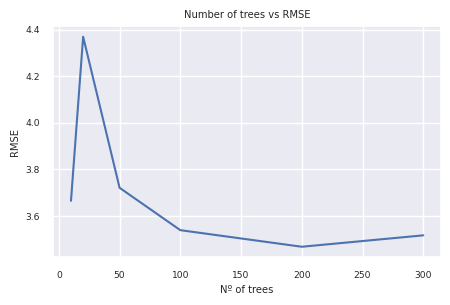

In [40]:
plt.figure(figsize=(5,3))
plt.plot(num_trees, rmses)
plt.xlabel('Nº of trees')
plt.ylabel('RMSE')
plt.title('Number of trees vs RMSE')
plt.show()

After 300 trees, the RMSE on validation data starts to increase. 

Now, we evaluate the performance for different values of the `max_depth` parameter.

In [41]:
all_rmses_depth = {}
depth_list = [5, 10, 20, None]

for depth in depth_list:
    print('max_depth: %s' % depth)

    rmses = []
    for trees in num_trees:
        rfr = RandomForestRegressor(n_estimators=trees, 
                                    max_depth=depth, 
                                    random_state=3)
        pipe_rfr = make_pipeline(rfr, X_train)

        pipe_rfr.fit(X_train, y_train)

        y_pred = pipe_rfr.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        print('%3s -> %.3f' % (trees, rmse))

        rmses.append(rmse)
    
    print()

    all_rmses_depth[depth] = rmses

max_depth: 5
 10 -> 9.022
 20 -> 9.135
 50 -> 8.876
100 -> 8.719
200 -> 8.608
300 -> 8.641

max_depth: 10
 10 -> 3.748
 20 -> 4.119
 50 -> 3.772
100 -> 3.554
200 -> 3.510
300 -> 3.575

max_depth: 20
 10 -> 3.641
 20 -> 4.032
 50 -> 3.550
100 -> 3.416
200 -> 3.405
300 -> 3.470

max_depth: None
 10 -> 3.665
 20 -> 4.369
 50 -> 3.721
100 -> 3.539
200 -> 3.468
300 -> 3.517



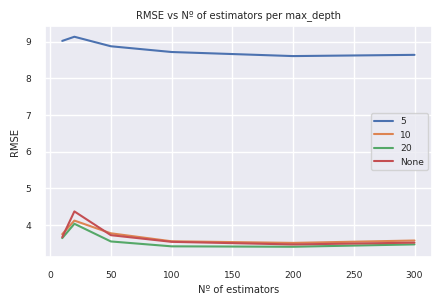

In [42]:
plt.figure(figsize=(5,3))
for depth in depth_list:
    if depth == None:
        plt.plot(num_trees, all_rmses_depth[depth], '-', label="None")
    else:
        plt.plot(num_trees, all_rmses_depth[depth], '-', label=depth)
plt.xlabel('Nº of estimators')
plt.ylabel('RMSE')
plt.legend()
plt.title('RMSE vs Nº of estimators per max_depth')
plt.show()

`max_depth=5` yields really bad results. Let's zoom the plot on the 10, 20 and None values.

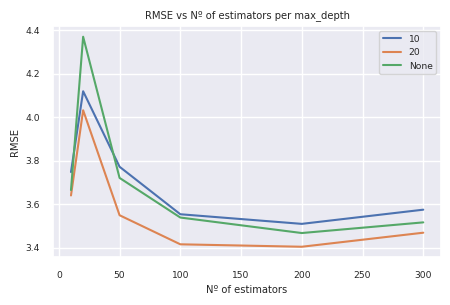

In [43]:
plt.figure(figsize=(5,3))
for depth in [10,20,None]:
    if depth == None:
        plt.plot(num_trees, all_rmses_depth[depth], '-', label="None")
    else:
        plt.plot(num_trees, all_rmses_depth[depth], '-', label=depth)
plt.xlabel('Nº of estimators')
plt.ylabel('RMSE')
plt.legend()
plt.title('RMSE vs Nº of estimators per max_depth')
plt.show()

The best RMSE is reached when `max_depth=20`, so we fix this parameter and assess the effect of the `min_samples_leaf` parameter.

In [44]:
all_rmses_leaf = {}
leaf_list = [1, 2, 3, 4]

for leaf in leaf_list:
    print('min_samples_leaf: %s' % leaf)

    rmses = []
    for trees in num_trees:
        rfr = RandomForestRegressor(n_estimators=trees,
                                    max_depth=20, 
                                    min_samples_leaf=leaf, 
                                    random_state=3)
        pipe_rfr = make_pipeline(rfr, X_train)
        pipe_rfr.fit(X_train, y_train)

        y_pred = pipe_rfr.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        print('%3s -> %.3f' % (trees, rmse))

        rmses.append(rmse)
    
    print()

    all_rmses_leaf[leaf] = rmses

min_samples_leaf: 1
 10 -> 3.641
 20 -> 4.032
 50 -> 3.550
100 -> 3.416
200 -> 3.405
300 -> 3.470

min_samples_leaf: 2
 10 -> 4.342
 20 -> 4.528
 50 -> 3.958
100 -> 3.748
200 -> 3.674
300 -> 3.714

min_samples_leaf: 3
 10 -> 4.403
 20 -> 4.690
 50 -> 4.196
100 -> 4.076
200 -> 4.004
300 -> 4.034

min_samples_leaf: 4
 10 -> 4.730
 20 -> 5.055
 50 -> 4.624
100 -> 4.417
200 -> 4.335
300 -> 4.379



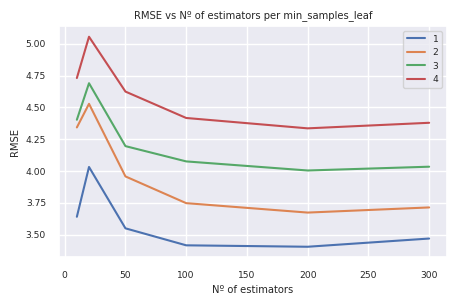

In [45]:
plt.figure(figsize=(5,3))
for leaf in leaf_list:
    plt.plot(num_trees, all_rmses_leaf[leaf], '-', label=leaf)
plt.xlabel('Nº of estimators')
plt.ylabel('RMSE')
plt.legend()
plt.title('RMSE vs Nº of estimators per min_samples_leaf')
plt.show()

The best result is with `min_samples_leaf = 1`. 

In [46]:
all_rmses_split = {}
split_list = [2, 4, 6, 8]

for split in split_list:
    print('min_samples_split: %s' % split)

    rmses = []
    for trees in num_trees:
        rfr = RandomForestRegressor(n_estimators=trees,
                                    max_depth=20,
                                    min_samples_leaf=1, 
                                    min_samples_split=split, 
                                    random_state=3)
        pipe_rfr = make_pipeline(rfr, X_train)
        pipe_rfr.fit(X_train, y_train)

        y_pred = pipe_rfr.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        print('%3s -> %.3f' % (trees, rmse))

        rmses.append(rmse)
    
    print()

    all_rmses_split[split] = rmses

min_samples_split: 2
 10 -> 3.641
 20 -> 4.032
 50 -> 3.550
100 -> 3.416
200 -> 3.405
300 -> 3.470

min_samples_split: 4
 10 -> 3.928
 20 -> 3.901
 50 -> 3.531
100 -> 3.406
200 -> 3.367
300 -> 3.444

min_samples_split: 6
 10 -> 4.105
 20 -> 4.418
 50 -> 3.896
100 -> 3.654
200 -> 3.587
300 -> 3.591

min_samples_split: 8
 10 -> 4.249
 20 -> 4.613
 50 -> 3.913
100 -> 3.722
200 -> 3.698
300 -> 3.734



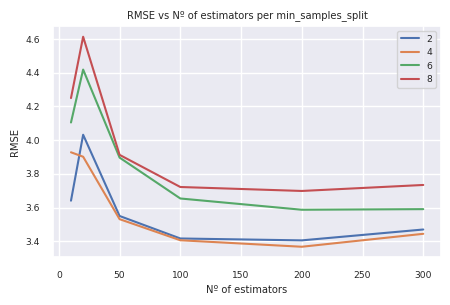

In [47]:
plt.figure(figsize=(5,3))
for split in split_list:
    plt.plot(num_trees, all_rmses_split[split], '-', label=split)
plt.xlabel('Nº of estimators')
plt.ylabel('RMSE')
plt.legend()
plt.title('RMSE vs Nº of estimators per min_samples_split')
plt.show()

The best value is `min_samples_split = 4`.

### Test Data - Random Forest
Now, we are going to train the model using the full train dataset (train+validation) using Randomized Search crossing validation (a full Grid Search would take too long).

In [48]:
from sklearn.model_selection import RandomizedSearchCV

rfr = RandomForestRegressor()

pipe_rfr_cv = make_pipeline(rfr, X_train_full)

param_grid_rfr = {
    'model__max_depth': depth_list,
    'model__n_estimators': num_trees,
    'model__min_samples_leaf': leaf_list,
    'model__min_samples_split': split_list,
}

rs_cv_rfr = RandomizedSearchCV(estimator = pipe_rfr_cv,
                               param_distributions = param_grid_rfr,
                               n_iter=30, cv=5,
                               verbose=0, scoring='neg_root_mean_squared_error',
                               random_state=3, n_jobs = -1)

rs_cv_rfr.fit(X_train_full, y_train_full)

y_pred_train_full = rs_cv_rfr.predict(X_train_full)
y_pred_test = rs_cv_rfr.predict(X_test)

rfr_score_train_full = np.sqrt(mean_squared_error(y_train_full, y_pred_train_full))
rfr_score_test = np.sqrt(mean_squared_error(y_test, y_pred_test))

rfr_results = pd.DataFrame({"Model": ["Random Forest"] * 2,
                            "Dataset": ["Train", "Test"],
                            "Score": [rfr_score_train_full, rfr_score_test]
                           })

final_scores = pd.concat([final_scores, rfr_results])

print("RMSE Train = {:0.3f}".format(rfr_score_train_full))
print("RMSE Test = {:0.3f}".format(rfr_score_test))
print(rs_cv_rfr.best_params_)

RMSE Train = 1.218
RMSE Test = 1.898
{'model__n_estimators': 20, 'model__min_samples_split': 4, 'model__min_samples_leaf': 1, 'model__max_depth': 20}


## XGBoost Regressor
Finally, our last model is the Extreme Gradient Boosting Regressor. We are going to repeat the same procedures for the Random Forest Regressor, but with the the number of estimator, `max_depth` and `eta` (learning rate) parameters.

In [49]:
from xgboost import XGBRegressor

model_xgb = XGBRegressor(random_state=5)

pipe_xgb = make_pipeline(model_xgb, X_train_full)

pipe_xgb.fit(X_train_full, y_train_full)

pred_train_full_xgb = pipe_xgb.predict(X_train_full)
pred_test_xgb = pipe_xgb.predict(X_test)

xgb_score_train_full = np.sqrt(mean_squared_error(y_train_full, pred_train_full_xgb))
xgb_score_test = np.sqrt(mean_squared_error(y_test, pred_test_xgb))

print("RMSE Train = {:0.3f}".format(xgb_score_train_full))
print("RMSE Test = {:0.3f}".format(xgb_score_test))

RMSE Train = 0.821
RMSE Test = 2.052


In [50]:
num_trees = [10, 20, 50, 100, 200]

rmses_train = []
rmses_val = []
for n in num_trees:

    model_xgb = XGBRegressor(n_estimators=n, random_state=5)

    pipe_xgb = make_pipeline(model_xgb, X_train)

    pipe_xgb.fit(X_train, y_train)

    y_pred_train = pipe_xgb.predict(X_train)
    y_pred_val = pipe_xgb.predict(X_val)


    rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
    rmse_val = np.sqrt(mean_squared_error(y_val, y_pred_val))
    print('%3s -> train: %.3f / val: %.3f' % (n, rmse_train, rmse_val))

    rmses_train.append(rmse_train)
    rmses_val.append(rmse_val)

 10 -> train: 8.407 / val: 9.328
 20 -> train: 2.140 / val: 3.368
 50 -> train: 1.260 / val: 2.830
100 -> train: 0.769 / val: 2.645
200 -> train: 0.437 / val: 2.557


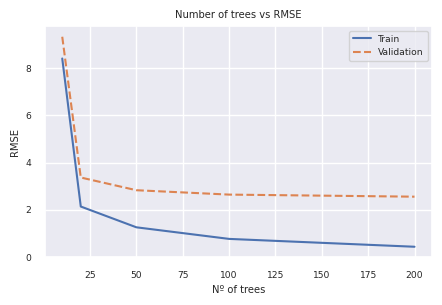

In [51]:
plt.figure(figsize=(5,3))
plt.plot(num_trees, rmses_train, label="Train")
plt.plot(num_trees, rmses_val, linestyle='--', label="Validation")
plt.xlabel('Nº of trees')
plt.ylabel('RMSE')
plt.legend()
plt.title('Number of trees vs RMSE')
plt.show()

With increasing number of trees, the model is more prone to overfitting.

Let's assess the effect of the `max_depth` parameter.

In [52]:
xgb_rmses_train_depth = {}
xgb_rmses_val_depth = {}

depth_list = [3, 5, 7, 9]

for depth in depth_list:
    print('max_depth: %s' % depth)

    rmses_train = []
    rmses_val = []
    for trees in num_trees:
        xgb = XGBRegressor(n_estimators=trees, 
                           max_depth=depth, 
                           random_state=3)

        pipe_xgb = make_pipeline(xgb, X_train)

        pipe_xgb.fit(X_train, y_train)

        y_pred_train = pipe_xgb.predict(X_train)
        y_pred_val = pipe_xgb.predict(X_val)

        rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
        rmse_val = np.sqrt(mean_squared_error(y_val, y_pred_val))

        print('%3s -> train: %.3f / val: %.3f' % (trees, rmse_train, rmse_val))

        rmses_train.append(rmse_train)
        rmses_val.append(rmse_val)

    
    print()

    xgb_rmses_train_depth[depth] = rmses_train
    xgb_rmses_val_depth[depth] = rmses_val

max_depth: 3
 10 -> train: 9.948 / val: 10.572
 20 -> train: 4.190 / val: 5.207
 50 -> train: 2.790 / val: 3.845
100 -> train: 1.936 / val: 3.184
200 -> train: 1.381 / val: 2.813

max_depth: 5
 10 -> train: 8.532 / val: 9.461
 20 -> train: 2.514 / val: 3.600
 50 -> train: 1.633 / val: 2.902
100 -> train: 1.039 / val: 2.539
200 -> train: 0.651 / val: 2.433

max_depth: 7
 10 -> train: 8.400 / val: 9.357
 20 -> train: 1.839 / val: 3.083
 50 -> train: 1.016 / val: 2.667
100 -> train: 0.566 / val: 2.500
200 -> train: 0.331 / val: 2.445

max_depth: 9
 10 -> train: 8.392 / val: 9.327
 20 -> train: 1.477 / val: 2.960
 50 -> train: 0.668 / val: 2.524
100 -> train: 0.353 / val: 2.448
200 -> train: 0.249 / val: 2.435



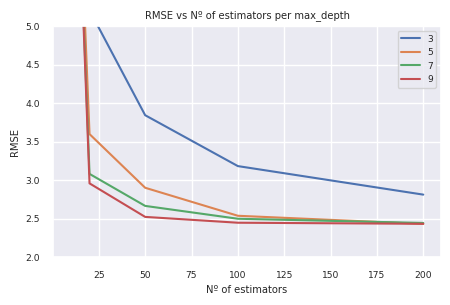

In [53]:
plt.figure(figsize=(5,3))
for depth in depth_list:
    plt.plot(num_trees, xgb_rmses_val_depth[depth], '-', label=str(depth))
plt.xlabel('Nº of estimators')
plt.ylabel('RMSE')
plt.ylim([2, 5])
plt.legend()
plt.title('RMSE vs Nº of estimators per max_depth')
plt.show()

`max_depth=9` yields the best RMSE. Fixing this parameter, let's find the best `eta`:

In [54]:
xgb_rmses_train_eta = {}
xgb_rmses_val_eta = {}

eta_list = [0.1, 0.2, 0.3, 0.5]
for eta in eta_list:
    print('eta: %s' % eta)

    rmses_train = []
    rmses_val = []
    for trees in num_trees:
        xgb = XGBRegressor(n_estimators=trees,
                           max_depth=9,
                           eta = eta,
                           random_state=3)

        pipe_xgb = make_pipeline(xgb, X_train)

        pipe_xgb.fit(X_train, y_train)

        y_pred_train = pipe_xgb.predict(X_train)
        y_pred_val = pipe_xgb.predict(X_val)

        rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
        rmse_val = np.sqrt(mean_squared_error(y_val, y_pred_val))

        print('%3s -> train: %.3f / val: %.3f' % (trees, rmse_train, rmse_val))

        rmses_train.append(rmse_train)
        rmses_val.append(rmse_val)

    
    print()

    xgb_rmses_train_eta[eta] = rmses_train
    xgb_rmses_val_eta[eta] = rmses_val

eta: 0.1
 10 -> train: 91.739 / val: 92.847
 20 -> train: 32.573 / val: 33.285
 50 -> train: 2.149 / val: 3.282
100 -> train: 0.900 / val: 2.423
200 -> train: 0.520 / val: 2.315

eta: 0.2
 10 -> train: 28.907 / val: 29.387
 20 -> train: 3.863 / val: 4.619
 50 -> train: 0.957 / val: 2.396
100 -> train: 0.536 / val: 2.278
200 -> train: 0.300 / val: 2.236

eta: 0.3
 10 -> train: 8.392 / val: 9.327
 20 -> train: 1.477 / val: 2.960
 50 -> train: 0.668 / val: 2.524
100 -> train: 0.353 / val: 2.448
200 -> train: 0.249 / val: 2.435

eta: 0.5
 10 -> train: 1.592 / val: 3.074
 20 -> train: 0.927 / val: 2.722
 50 -> train: 0.423 / val: 2.597
100 -> train: 0.260 / val: 2.584
200 -> train: 0.241 / val: 2.580



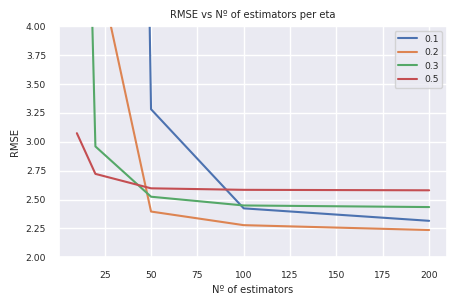

In [55]:
plt.figure(figsize=(5,3))
for eta in eta_list:
    plt.plot(num_trees, xgb_rmses_val_eta[eta], '-', label=eta)
plt.xlabel('Nº of estimators')
plt.ylabel('RMSE')
plt.ylim([2, 4])
plt.legend()
plt.title('RMSE vs Nº of estimators per eta')
plt.show()

The best value is `eta=0.2`. 
### Test - XGBoost Regressor
Repeating training on full dataset using RandomizedSearchCV and testing on unseen data:

In [56]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor

model_xgb = XGBRegressor()

pipe_xgb = make_pipeline(model_xgb, X_train_full)

param_grid_xgb = {
    'model__max_depth': depth_list,
    'model__n_estimators': num_trees,
    'model__eta': eta_list,
}

rs_cv_xgb = RandomizedSearchCV(estimator = pipe_xgb,
                               param_distributions = param_grid_xgb,
                               n_iter=30, cv=5,
                               verbose=0, scoring='neg_root_mean_squared_error',
                               random_state=3, n_jobs=-1)
                               

rs_cv_xgb.fit(X_train_full, y_train_full)

pred_train_full_xgb = rs_cv_xgb.predict(X_train_full)
pred_test_xgb = rs_cv_xgb.predict(X_test)

xgb_score_train_full = np.sqrt(mean_squared_error(y_train_full, pred_train_full_xgb))
xgb_score_test = np.sqrt(mean_squared_error(y_test, pred_test_xgb))

xgb_results = pd.DataFrame({"Model": ["XGBoost"] * 2,
                            "Dataset": ["Train", "Test"],
                            "Score": [xgb_score_train_full, xgb_score_test]
                           })

final_scores = pd.concat([final_scores, xgb_results])

print("RMSE Train = {:0.3f}".format(xgb_score_train_full))
print("RMSE Test = {:0.3f}".format(xgb_score_test))
print(rs_cv_xgb.best_params_)

RMSE Train = 0.491
RMSE Test = 1.803
{'model__n_estimators': 200, 'model__max_depth': 7, 'model__eta': 0.2}


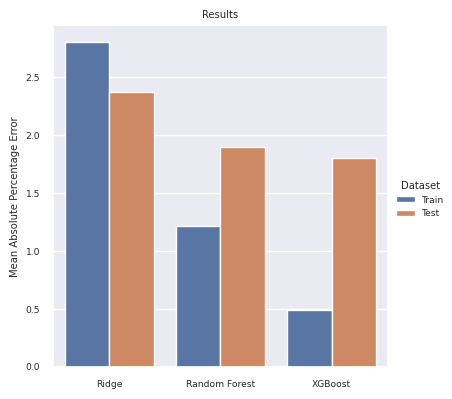

In [57]:
sns.catplot(x='Model', y='Score', data=final_scores, hue='Dataset', kind='bar', aspect=1, height=4)
plt.title('Results')
plt.xlabel('')
plt.ylabel('Mean Absolute Percentage Error')
plt.show()

From this plot, we can take the following conclusions:

- the Ridge regressor is the best model in terms of generalization to unseen data, as it shows the smallest difference between training and test scores. However, its performance on the test data is worst than the other tree-based models.
- The Random Forest presents high overfitting, but its performance on training and test datasets is better than the Ridge regressor model.  
- The same applies to the XGBoost model, which has the best overall performance, with the lowest RMSE for both training and test data.

From these considerations, we can conclude that the XGBoost model is the best for this example.

## Feature Engineering

Now, let's try removing the 'fuel consumption city (l/100 km)' and 'fuel consumption hwy (l/100 km)' columns, and keep the combination of both, 'fuel consumption comb (l/100 km)', and see if this help us to avoid overfitting.  

We are going to use the full training dataset with cross validation and Grid/Randomized Search with the same set of parameters we've used earlier. 

In [58]:
# Creating target series
y_train_full = df_train_full['co2 emissions (g/km)']
y_test = df_test['co2 emissions (g/km)']

# Removing target from train sets
drop_cols = ['co2 emissions (g/km)', 
             'model', 
             'fuel consumption comb (mpg)', 
             'fuel consumption city (l/100 km)',
             'fuel consumption hwy (l/100 km)',
            ]

X_train_full = df_train_full.drop(drop_cols, axis=1)
X_test = df_test.drop(drop_cols, axis=1)

In [59]:
final_scores_mod = pd.DataFrame({"Model": [], 
                                 "Dataset": [], 
                                 "Score":[]})

## Ridge Regression

In [60]:
from sklearn.model_selection import GridSearchCV

rdg_final = Ridge()
pipe_rdg_final = make_pipeline(rdg_final, X_train_full)

param_grid_rdg = {'model__alpha': alpha_list}

gs_cv_rdg = GridSearchCV(pipe_rdg_final, param_grid_rdg,
                         scoring='neg_root_mean_squared_error', cv=5)

gs_cv_rdg.fit(X_train_full, y_train_full)

y_pred_train_full = gs_cv_rdg.predict(X_train_full)
y_pred_test = gs_cv_rdg.predict(X_test)

rdg_score_train_full = np.sqrt(mean_squared_error(y_train_full, y_pred_train_full))
rdg_score_test = np.sqrt(mean_squared_error(y_test, y_pred_test))

rdg_results_mod = pd.DataFrame({"Model": ["Ridge"] * 2,
                                 "Dataset": ["Train", "Test"],
                                 "Score": [rdg_score_train_full, rdg_score_test]
                                })

final_scores_mod = pd.concat([final_scores_mod, rdg_results_mod])

print("RMSE Train = {:0.3f}".format(rdg_score_train_full))
print("RMSE Test = {:0.3f}".format(rdg_score_test))
print(gs_cv_rdg.best_params_)

RMSE Train = 2.815
RMSE Test = 2.344
{'model__alpha': 0.1}


## Random Forest Regressor

In [61]:
from sklearn.model_selection import RandomizedSearchCV

rfr = RandomForestRegressor()

pipe_rfr_cv = make_pipeline(rfr, X_train_full)

num_trees = [10, 20, 50, 100, 200, 300]
depth_list = [5, 10, 20, None]
leaf_list = [1, 2, 3, 4]
split_list = [2, 4, 6, 8]

param_grid_rfr = {
    'model__max_depth': depth_list,
    'model__n_estimators': num_trees,
    'model__min_samples_leaf': leaf_list,
    'model__min_samples_split': split_list,
}

rs_cv_rfr = RandomizedSearchCV(estimator = pipe_rfr_cv,
                               param_distributions = param_grid_rfr,
                               n_iter=30, cv=5,
                               verbose=0, scoring='neg_root_mean_squared_error',
                               random_state=3, n_jobs = -1)

rs_cv_rfr.fit(X_train_full, y_train_full)

y_pred_train_full = rs_cv_rfr.predict(X_train_full)
y_pred_test = rs_cv_rfr.predict(X_test)

rfr_score_train_full = np.sqrt(mean_squared_error(y_train_full, y_pred_train_full))
rfr_score_test = np.sqrt(mean_squared_error(y_test, y_pred_test))

rfr_results_mod = pd.DataFrame({"Model": ["Random Forest"] * 2,
                                "Dataset": ["Train", "Test"],
                                "Score": [rfr_score_train_full, rfr_score_test]
                               })

final_scores_mod = pd.concat([final_scores, rfr_results_mod])

print("RMSE Train = {:0.3f}".format(rfr_score_train_full))
print("RMSE Test = {:0.3f}".format(rfr_score_test))
print(rs_cv_rfr.best_params_)

RMSE Train = 0.992
RMSE Test = 1.515
{'model__n_estimators': 20, 'model__min_samples_split': 4, 'model__min_samples_leaf': 1, 'model__max_depth': 20}


## XGBoost Regressor

In [62]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor

model_xgb = XGBRegressor()

pipe_xgb = make_pipeline(model_xgb, X_train_full)

num_trees = [10, 20, 50, 100, 200]
depth_list = [3, 5, 7, 9]
eta_list = [0.1, 0.2, 0.3, 0.5]

param_grid_xgb = {
    'model__max_depth': depth_list,
    'model__n_estimators': num_trees,
    'model__eta': eta_list,
}

rs_cv_xgb = RandomizedSearchCV(estimator = pipe_xgb,
                               param_distributions = param_grid_xgb,
                               n_iter=30, cv=5,
                               verbose=0, scoring='neg_root_mean_squared_error',
                               random_state=3, n_jobs=-1)
                               

rs_cv_xgb.fit(X_train_full, y_train_full)

pred_train_full_xgb = rs_cv_xgb.predict(X_train_full)
pred_test_xgb = rs_cv_xgb.predict(X_test)

xgb_score_train_full = np.sqrt(mean_squared_error(y_train_full, pred_train_full_xgb))
xgb_score_test = np.sqrt(mean_squared_error(y_test, pred_test_xgb))

xgb_results_mod = pd.DataFrame({"Model": ["XGBoost"] * 2,
                                "Dataset": ["Train", "Test"],
                                "Score": [xgb_score_train_full, xgb_score_test]
                               })

final_scores_mod = pd.concat([final_scores_mod, xgb_results_mod])

print("RMSE Train = {:0.3f}".format(xgb_score_train_full))
print("RMSE Test = {:0.3f}".format(xgb_score_test))
print(rs_cv_xgb.best_params_)

RMSE Train = 0.546
RMSE Test = 1.338
{'model__n_estimators': 200, 'model__max_depth': 7, 'model__eta': 0.2}


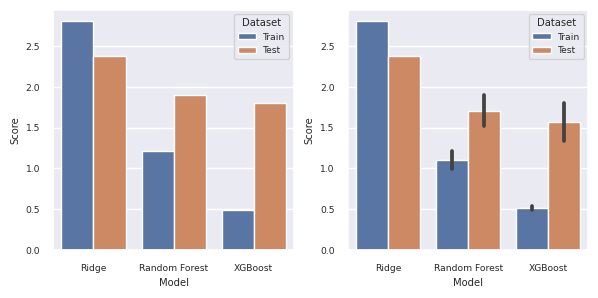

In [63]:
fig = plt.figure(figsize=(6,3))

ax1 = fig.add_subplot(121)
sns.barplot(x='Model', y='Score', data=final_scores, hue='Dataset')

ax2 = fig.add_subplot(122)
g = sns.barplot(x='Model', y='Score', data=final_scores_mod, hue='Dataset')

plt.close(2)
plt.close(3)
plt.tight_layout()

Using the combination of fuel consumption, we've got slightly better results. The XGBoost Regressor had the lowest RMSE so far on the test data set, so this is the model we are going to use. 